In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import kmapper as km
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import iqr
import networkx as nx
import hdbscan
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [26]:
df_departures = pd.read_pickle("../../calculated_distances_dep.pkl")

df_arrivals = pd.read_pickle("../../calculated_distances_arr.pkl")

print("Columns all:")
print(df_departures.columns.tolist())

Columns all:
['airportCode', 'date', 'deviation', 'delay']


In [27]:
df_arrivals_long_delay = df_arrivals[df_arrivals['delay'] < -500]
print(df_arrivals_long_delay)

       airportCode       date    deviation       delay
565414        LEAB 2018-09-22  1943.935833 -556.766667


In [28]:
# Filter month july

df_departures = df_departures[df_departures['date'].dt.month == 7]

df_arrivals = df_arrivals[df_arrivals['date'].dt.month == 7]

In [29]:
df_dep_by_airport = df_departures.groupby(['airportCode']).agg({
    'deviation': ['mean', 'median', 'std', iqr],
    'delay': ['mean', 'median', 'std', iqr]
}).reset_index()

df_dep_by_airport.columns = ['airportCode',
                            'deviation_mean', 'deviation_median', 'deviation_std', 'deviation_iqr',
                            'delay_mean', 'delay_median', 'delay_std', 'delay_iqr']

df_arr_by_airport = df_arrivals.groupby(['airportCode']).agg({
    'deviation': ['mean', 'median', 'std', iqr],
    'delay': ['mean', 'median', 'std', iqr]
}).reset_index()


df_arr_by_airport.columns = ['airportCode',
                            'deviation_mean', 'deviation_median', 'deviation_std', 'deviation_iqr',
                            'delay_mean', 'delay_median', 'delay_std', 'delay_iqr']

df_all_by_airport = pd.merge(df_dep_by_airport, df_arr_by_airport, on=['airportCode'], suffixes=('_dep', '_arr'))



print(df_all_by_airport.head())

print(df_all_by_airport.shape)

  airportCode  deviation_mean_dep  deviation_median_dep  deviation_std_dep  \
0        GCFV         2408.912873           1379.978347        2678.414455   
1        GCGM          257.964160            206.325970         149.340054   
2        GCHI          383.182051            344.467855         206.478628   
3        GCLA          826.900769            259.799908        1484.988901   
4        GCLP         1625.577684            570.762455        2401.893450   

   deviation_iqr_dep  delay_mean_dep  delay_median_dep  delay_std_dep  \
0        2527.309003        0.924019         -1.441667      15.769071   
1         197.600618       -1.986290         -3.508333       6.455884   
2         284.424051       -1.899265         -2.808333       7.677295   
3         361.257725       -1.263199         -2.358333       8.188170   
4        2163.328901        1.501304         -0.233333      12.712406   

   delay_iqr_dep  deviation_mean_arr  deviation_median_arr  deviation_std_arr  \
0      16.9

In [30]:
df_dep_by_airport.fillna({'deviation_std': 0.0, 'delay_std': 0.0}, inplace=True)
print(df_dep_by_airport.isna().sum())

print()
df_arr_by_airport.fillna({'deviation_std': 0.0, 'delay_std': 0.0}, inplace=True)
print(df_arr_by_airport.isna().sum())


print()
df_all_by_airport.fillna({'deviation_std_dep': 0.0, 'delay_std_dep': 0.0, 'deviation_std_arr': 0.0, 'delay_std_arr': 0.0}, inplace=True)
print(df_all_by_airport.isna().sum())

airportCode         0
deviation_mean      0
deviation_median    0
deviation_std       0
deviation_iqr       0
delay_mean          0
delay_median        0
delay_std           0
delay_iqr           0
dtype: int64

airportCode         0
deviation_mean      0
deviation_median    0
deviation_std       0
deviation_iqr       0
delay_mean          0
delay_median        0
delay_std           0
delay_iqr           0
dtype: int64

airportCode             0
deviation_mean_dep      0
deviation_median_dep    0
deviation_std_dep       0
deviation_iqr_dep       0
delay_mean_dep          0
delay_median_dep        0
delay_std_dep           0
delay_iqr_dep           0
deviation_mean_arr      0
deviation_median_arr    0
deviation_std_arr       0
deviation_iqr_arr       0
delay_mean_arr          0
delay_median_arr        0
delay_std_arr           0
delay_iqr_arr           0
dtype: int64


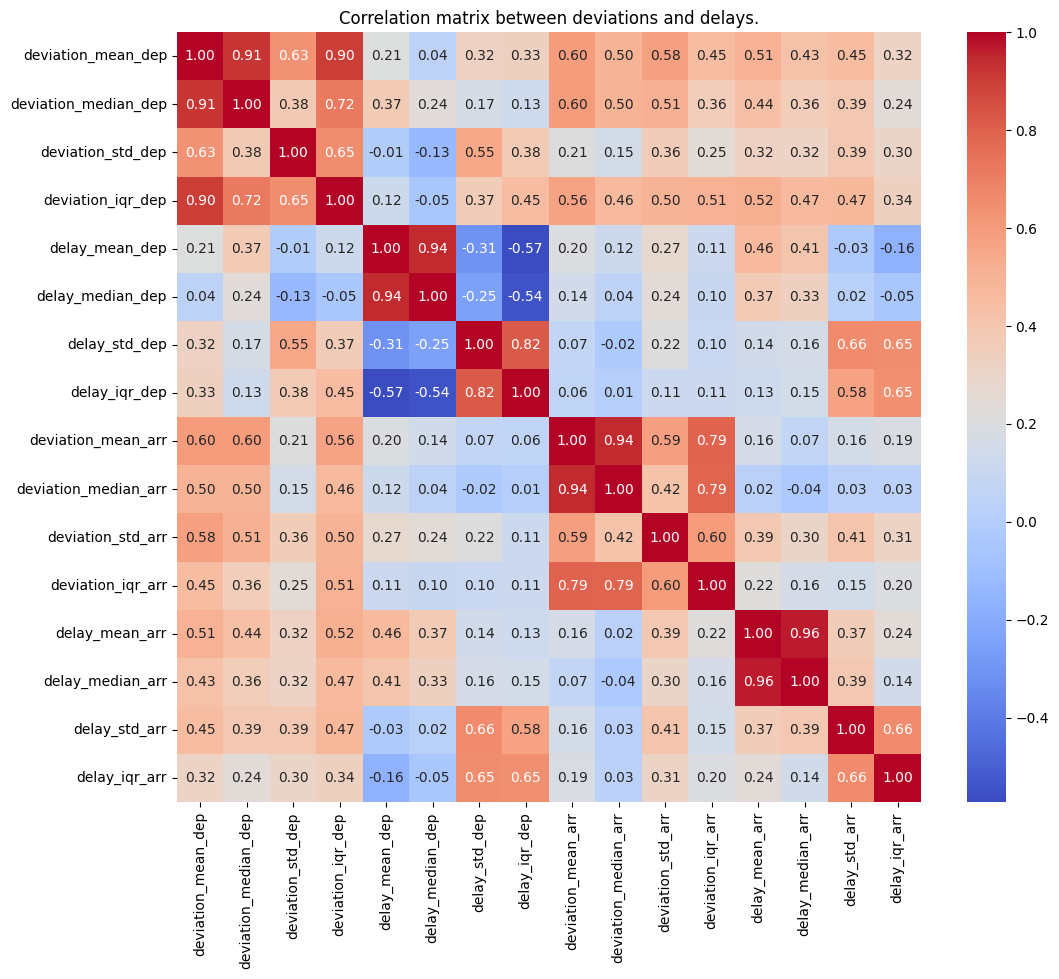

In [31]:
df_numeric = df_all_by_airport.drop(columns=['airportCode'])

corr_matrix = df_numeric.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix between deviations and delays.")
plt.show()

In [32]:
df_spanish_airports = pd.read_pickle('../../spanish_airports.pkl')

X_all = df_all_by_airport.drop(columns=['airportCode']).dropna()

print(X_all.head())
print()

scaler = StandardScaler()
X_scaled_all = scaler.fit_transform(X_all)

custom_tooltips_all = np.array([
     f"{df_spanish_airports.loc[df_spanish_airports['ICAO'] == row['airportCode'], 'Aeropuerto'].values[0] }" for _, row in df_all_by_airport.iterrows()
])

print(X_scaled_all)

   deviation_mean_dep  deviation_median_dep  deviation_std_dep  \
0         2408.912873           1379.978347        2678.414455   
1          257.964160            206.325970         149.340054   
2          383.182051            344.467855         206.478628   
3          826.900769            259.799908        1484.988901   
4         1625.577684            570.762455        2401.893450   

   deviation_iqr_dep  delay_mean_dep  delay_median_dep  delay_std_dep  \
0        2527.309003        0.924019         -1.441667      15.769071   
1         197.600618       -1.986290         -3.508333       6.455884   
2         284.424051       -1.899265         -2.808333       7.677295   
3         361.257725       -1.263199         -2.358333       8.188170   
4        2163.328901        1.501304         -0.233333      12.712406   

   delay_iqr_dep  deviation_mean_arr  deviation_median_arr  deviation_std_arr  \
0      16.904167         3098.902492           3851.207115        2588.007047   
1 

In [33]:
def graph_stats(graph):
    G = nx.Graph()
    for node_id in graph['nodes'].keys():
        members = graph['nodes'][node_id]
        nombres_miembros = [custom_tooltips_all[i] for i in members]
        G.add_node(node_id, members=nombres_miembros)
    
    for source, targets in graph['links'].items():
        for target in targets:
            G.add_edge(source, target)

    num_nodos = len(graph['nodes'])
    num_enlaces = len(graph['links'])
    densidad = (2 * num_enlaces) / (num_nodos * (num_nodos - 1)) if num_nodos > 1 else 0
    grados = dict(G.degree()).values()
    grado_medio = sum(grados) / len(grados) if len(grados) > 0 else 0
    grado_max = max(grados) if grados else 0
    grado_min = min(grados) if grados else 0
    num_componentes = nx.number_connected_components(G)
    tamaños = [ len(data['members']) 
            for _, data in G.nodes(data=True) ]
    
    tamaño_medio = sum(tamaños) / len(tamaños)
    diametro = nx.diameter(G) if nx.is_connected(G) else max(nx.diameter(G.subgraph(c)) for c in nx.connected_components(G))
    coef_agrupamiento = nx.average_clustering(G) if len(G) > 1 else 0

    centralidad_grado = nx.degree_centrality(G)
    centralidad_betweenness = nx.betweenness_centrality(G)

    print("Número de nodos:", num_nodos)
    print("Número de enlaces:", num_enlaces)
    print("Densidad del grafo:", densidad)
    print("Grados:", grados)
    print("Grado medio de los nodos:", grado_medio)
    print("Grado máximo:", grado_max)
    print("Grado mínimo:", grado_min)
    print("Número de componentes conectados:", num_componentes)
    print("Tamaño medio de cluster:", tamaño_medio)
    print("Tamaños:", tamaños)
    print("Diámetro del grafo:", diametro)
    print("Coeficiente medio de agrupamiento:", coef_agrupamiento)
    print("Centralidad grado:", centralidad_grado)
    print("Centralidad betweeness:", centralidad_betweenness)
    print()
    print("-" * 30)

    for node_id, data in G.nodes(data=True):
        if(data and data['members']):    
            members = data['members']
            cluster_size = len(members)
            print(f"Clúster: {node_id}")
            print(f" - Número de miembros: {cluster_size}")
            print(f" - Miembros: {[str(member) for member in members]}")
            print("-" * 30)
            
    from collections import defaultdict

    apariciones_miembro = defaultdict(int)

    for _, data in G.nodes(data=True):
        if data and 'members' in data:
            for miembro in data['members']:
                apariciones_miembro[miembro] += 1

    print("\nNúmero de nodos en los que aparece cada miembro:")
    for miembro, conteo in apariciones_miembro.items():
        if conteo > 1:
            print(f" - {miembro}: {conteo} nodos")   
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, font_size=12, font_weight='bold')
    
    plt.show()

Número de nodos: 19
Número de enlaces: 6
Densidad del grafo: 0.03508771929824561
Grados: dict_values([0, 0, 1, 2, 1, 0, 1, 2, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0])
Grado medio de los nodos: 0.631578947368421
Grado máximo: 2
Grado mínimo: 0
Número de componentes conectados: 13
Tamaño medio de cluster: 3.0
Tamaños: [1, 1, 2, 2, 1, 3, 7, 12, 1, 1, 1, 6, 9, 1, 1, 4, 2, 1, 1]
Diámetro del grafo: 4
Coeficiente medio de agrupamiento: 0.0
Centralidad grado: {'cube0_cluster0': 0.0, 'cube1_cluster0': 0.0, 'cube2_cluster0': 0.05555555555555555, 'cube3_cluster0': 0.1111111111111111, 'cube4_cluster0': 0.05555555555555555, 'cube5_cluster0': 0.0, 'cube6_cluster0': 0.05555555555555555, 'cube7_cluster0': 0.1111111111111111, 'cube7_cluster1': 0.0, 'cube8_cluster0': 0.0, 'cube8_cluster1': 0.0, 'cube8_cluster2': 0.1111111111111111, 'cube9_cluster0': 0.1111111111111111, 'cube9_cluster1': 0.0, 'cube9_cluster2': 0.0, 'cube10_cluster0': 0.05555555555555555, 'cube11_cluster0': 0.0, 'cube11_cluster1': 0.0, 'cube11_

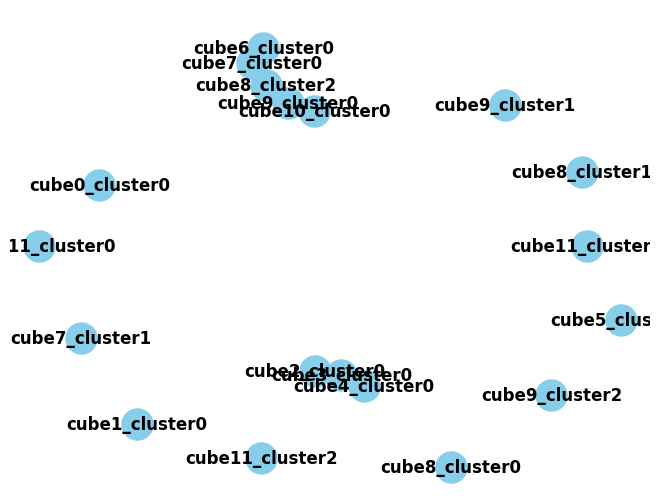

In [34]:
mapper = km.KeplerMapper()

pca = PCA(n_components=3)
filter_values_all = pca.fit_transform(X_scaled_all)

pca = PCA(n_components=1)

projection_all = pca.fit_transform(X_scaled_all)
 
graph_all = mapper.map(projection_all,
                       filter_values_all, 
                    clusterer=DBSCAN(eps=2.5, min_samples=1),
                    cover=km.Cover(n_cubes=12, perc_overlap=0.25)
)

color_values_all = X_scaled_all[:, :16]
color_function_name_all = X_all.columns[:16]

mapper.visualize(graph_all, 
                 path_html="mapper_output_all.html", 
                 custom_tooltips=custom_tooltips_all,
                 color_values=color_values_all,
                 color_function_name=color_function_name_all,
                 node_color_function=["mean", "std"])

graph_stats(graph_all)

Número de nodos: 10
Número de enlaces: 2
Densidad del grafo: 0.044444444444444446
Grados: dict_values([1, 0, 0, 1, 0, 0, 0, 1, 0, 1])
Grado medio de los nodos: 0.4
Grado máximo: 1
Grado mínimo: 0
Número de componentes conectados: 8
Tamaño medio de cluster: 3.9
Tamaños: [2, 4, 2, 5, 5, 2, 2, 10, 2, 5]
Diámetro del grafo: 1
Coeficiente medio de agrupamiento: 0.0
Centralidad grado: {'cube3_cluster0': 0.1111111111111111, 'cube3_cluster1': 0.0, 'cube4_cluster0': 0.0, 'cube4_cluster1': 0.1111111111111111, 'cube4_cluster2': 0.0, 'cube5_cluster0': 0.0, 'cube5_cluster1': 0.0, 'cube5_cluster2': 0.1111111111111111, 'cube6_cluster0': 0.0, 'cube6_cluster1': 0.1111111111111111}
Centralidad betweeness: {'cube3_cluster0': 0.0, 'cube3_cluster1': 0.0, 'cube4_cluster0': 0.0, 'cube4_cluster1': 0.0, 'cube4_cluster2': 0.0, 'cube5_cluster0': 0.0, 'cube5_cluster1': 0.0, 'cube5_cluster2': 0.0, 'cube6_cluster0': 0.0, 'cube6_cluster1': 0.0}

------------------------------
Clúster: cube3_cluster0
 - Número de mie

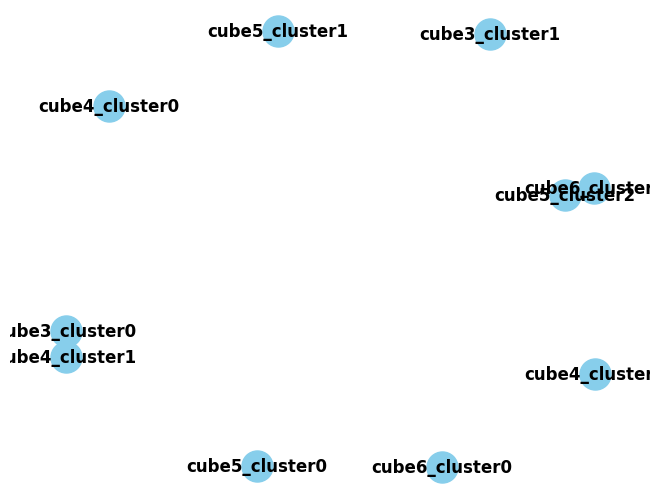

In [35]:
clusterer_all_ = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1)

graph_all_ = mapper.map(projection_all,
                         filter_values_all,
                         clusterer=clusterer_all_,
                         cover=km.Cover(n_cubes=7, perc_overlap=0.25)
)

mapper.visualize(graph_all_, 
                 path_html="mapper_output_all_.html",
                 custom_tooltips=custom_tooltips_all,
                 color_values=color_values_all,
                 color_function_name=color_function_name_all,
                 node_color_function=["mean", "std"])

graph_stats(graph_all_)

In [36]:
def get_airports_from_graph(graph, nodes=None):
    airports = set()
    if nodes is not None:
        for node_id in graph['nodes'].keys():
            members = graph['nodes'][node_id]
            if len(members) >= nodes:
                nombres_miembros = [custom_tooltips_all[i] for i in members]
                airports.update(nombres_miembros)
    else:
        for node_id in graph['nodes'].keys():
            members = graph['nodes'][node_id]
            nombres_miembros = [custom_tooltips_all[i] for i in members]
            airports.update(nombres_miembros)
        
    return airports

airports_DBSCAN = get_airports_from_graph(graph_all, 7)

airports_HDBSCAN = get_airports_from_graph(graph_all_)

airports_in_both = airports_DBSCAN & airports_HDBSCAN

print(f"Porcentaje de aeropuertos de DBSCAN {len(airports_in_both) / len(airports_DBSCAN) * 100}")
print(f"Porcentaje de aeropuertos de HDBSCAN {len(airports_in_both) / len(airports_HDBSCAN) * 100}")


Porcentaje de aeropuertos de DBSCAN 96.0
Porcentaje de aeropuertos de HDBSCAN 70.58823529411765
